# Modeling the scattering and the pulse profiles using shapelets in Fourier domain


In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install dynesty

import pypolychord as pp
#from pypolychord.settings import PolyChordSettings
##from pypolychord.priors import UniformPrior

import psrchive as p
import pylab
import scipy
from scipy.special import factorial
import numpy as np
import math
from multiprocessing import Pool
import dynesty
from dynesty import utils as dyfunc
import os
import time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


In [2]:

class Scattering():
    def __init__(self, filename, nchan=2, incScatter=True, incScatter_index=False, Nshapelets=1, nharm=40):
    
        self.pDM = (1,500)
        self.pSc = (-6,-1) # en log -> 10-6 a 10-1 s a 1 GHz -> 1us a 100 ms.
        self.pSci = (-5,-2)
        self.pW = (-4,4)
        self.incScatter = incScatter
        self.incScatter_index = incScatter_index
        self.reffreq = 1 # Reference frequency of 1 GHz
        # TODO: add circular prior on shapelet phase
    
        self.set_data(filename, nchan)
        
        # Determine the harmonic cutoff
        self.harm_cutoff = nharm
        self.nuc = self.nu[:self.harm_cutoff]
        
        self.set_NShapelets(Nshapelets)
        
        # Pre compute this term for the Shapelet profile
        self.term1 = np.zeros(Nshapelets, dtype=complex)
        for n in self.Scoeff:
            #print(n)
            #print(np.power(np.complex(0,1), n) * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5)
            self.term1[n] = np.power(np.complex(0,1), n) * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5
            #print(self.term1[n])
            
        print(self.term1)    
            
        # Precompute this term for the PBF
        self.twopif = 2*np.pi* self.nuc / self.period
                    
        
    def set_pDM(self, pDM):
        self.pDM = pDM
        
    def set_pSc(self, pSc):
        self.pSc = pSc
        
    def set_pSci(self, pSci):
        self.pScu = pSci
        
    def set_nharm(self, nharm):    
        self.harm_cutoff = nharm
    
    def fft_rotate(self, arr, phase):
        """
        fft_rotate(arr, phase):
            Return array 'arr' rotated by 'phase' to the left.  The
                rotation is done in the Fourier domain using the Shift Theorem.
                'phase' is between 0 and 1.  The resulting vector will have
                the same length as the original.
        """
        arr = np.asarray(arr)
        freqs = np.arange(arr.size / 2 + 1, dtype=np.float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return np.fft.irfft(phasor * np.fft.rfft(arr), arr.size)
    
    def rotate(self, arr, phase):
        """                                                                         
        fft_rotate(arr, phase):                                                      
            Return array 'arr' rotated by "phase" to the left.  The           
                rotation is done using the Shift Theorem assuming arr is in freq domain.     
                'phase' is fractional between 0 and 1.  The resulting vector will have           
                the same length as the original.                                    
        """
        freqs = np.arange(arr.size, dtype=np.float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return arr * phasor

    def PBF(self, tau, nu, alpha):
        """
        Pulse broadening function(f, tau, nu, alpha) from Lentati et al (2017), Eq. 10:
            Return the Fourier  pulse broadening function given:
             - tau: the scattering time scale
             - nu: the observing frequency
             - alpha: the scattering index
        """
        return 1/((self.twopif*nu**alpha * 10**tau)**2 + 1) + 1j*(-self.twopif*nu**alpha * 10**tau)/((self.twopif*nu**alpha*10**tau)**2 +1)


    def set_NShapelets(self, Nmax):
        # Number of shapelets coefficients
        self.Nmax = Nmax - 1 # The first shapelet coefficient is set to 1 
        self.Scoeff = np.arange(Nmax)
    
        # Construct array of Hermite polynomials
        self.hermit_ar = []
       
        for n in self.Scoeff:
            self.hermit_ar.append(scipy.special.hermite(n))
    
    def Prior(self, cube):
        pcube = np.zeros(cube.shape)
        ipar = 0
        
        # Shapelet width
        pcube[ipar] = 10**(cube[ipar] * (self.pW[1] - self.pW[0]) + self.pW[0]); ipar +=1
        
        # Overall Shapelet scaling factor (see eq. 7)
        pcube[ipar:ipar+self.nchan] = 10**((cube[ipar:ipar+self.nchan]*3)-1); ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            pcube[ipar] = cube[ipar] * (self.pDM[1] - self.pDM[0]) + self.pDM[0]
            ipar += 1
            
        # Scattering time scale at self.reffreq
        if self.incScatter:
            pcube[ipar] = (cube[ipar] * (self.pSc[1] - self.pSc[0]) + self.pSc[0])
            ipar += 1
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            pcube[ipar] = cube[ipar] * (self.pSci[1] - self.pSci[0]) + self.pSci[0]
            ipar += 1    
        
        # Shapelets amplitudes
        if self.Nmax:
            pcube[ipar:ipar+self.Nmax] = cube[ipar:ipar+self.Nmax]*3e2-1.5e2; ipar += self.Nmax
            
        return pcube
        
    def set_data(self, filename, nchan=4):
        try:
            arch = p.Archive_load(filename)
        except:
            raise
        self.nchan = nchan
        print("Tscrunching archive...")
        arch.tscrunch()
        print("Fscrunching archive to %d chans..."%nchan)
        arch.fscrunch_to_nchan(nchan)
        arch.pscrunch()
        #arch.bscrunch(16)
        arch.remove_baseline()
   
        integ = arch.get_first_Integration()
        
        # Get data
        data = arch.get_data()[0][0]
        maximums = np.max(data,axis=1)
        # Normalize the data
        self.prof = np.multiply(data.T, 1/maximums).T
        # FFT the profiles
        self.fftprof = np.fft.rfft(self.prof)
        
        # Get pulsar's period
        self.period = integ.get_folding_period()
        
        # Get channel frequencies
        self.obsfreq = arch.get_frequencies()/1000.  
        
        # Get number of profile bins
        self.nbin = arch.get_nbin()
        self.fftnbin = int(self.nbin / 2 + 1)
        print ("FFT bins = ", self.fftnbin)
        
        self.prof_stds = np.std(self.fftprof[:,self.fftnbin//2:], axis=-1)
        #self.prof_stds = np.ones(self.nchan) * 0.1
        
        # Create the frequencies array
        self.nu = np.arange(self.fftnbin, dtype=np.float)
        
    def plot_fftprofiles(self):    
        #pylab.subplot(self.nchan, 2, 1)
        for ichan in range(self.nchan):
            # Real
            pylab.subplot(self.nchan, 2, 2*ichan+1)
            pylab.title("Channel #%d - Real part"%ichan)
            pylab.plot(np.real(self.fftprof[ichan][:self.harm_cutoff]))
            pylab.plot(np.real(self.model[ichan]))
            # Imag 
            pylab.subplot(self.nchan, 2, 2*ichan+1+1)
            pylab.title("Channel #%d - Imaginary part"%ichan)
            pylab.plot(np.imag(self.fftprof[ichan][:self.harm_cutoff]))
            pylab.plot(np.imag(self.model[ichan]))

        
    def plot_profiles(self):
        # Plot the data
        pylab.subplot(2, 1, 1)
        for ichan in range(self.nchan):
            pylab.plot((self.prof[ichan]+ichan))
            
            model = np.fft.irfft(self.model[ichan], n=self.nbin)
            pylab.plot(model/np.max(model)+ichan, color='r')

        
    def shapelet_profile(self, Samp, width):
        
        nu_width = self.nuc * width
        #return sum(1j**n * Samp[n] * width**.5 * 1 * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width) for n in self.Scoeff)
        return sum(Samp[n] * width**.5 * self.term1[n] * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width) for n in self.Scoeff)
    
    def LogLikelihood(self, cube, DEBUG=False):
        #t0 = time.time()
        ipar = 0
        width = cube[ipar]; ipar +=1
        Amp = cube[ipar:ipar+self.nchan]; ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            DM = cube[ipar]; ipar += 1
            
        # Scattering time scale at XXX
        if self.incScatter:
            Tau = cube[ipar];ipar += 1
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            Tau_index = cube[ipar]; ipar += 1
        else: Tau_index = -3.8
        
        # Shapelets amplitudes (the first Shapelet amplitude is set to 1)
        if self.Nmax:
            Samp = np.append(np.array([1]), cube[ipar:ipar+self.Nmax]); ipar += self.Nmax
        else: Samp = np.array([1]) 

        # Construct the FFT model with Shapelets amplitude and widths.
        #t1 = time.time()
        self.fftmodel = self.shapelet_profile(Samp, width)
        
        
        self.model = np.zeros((self.nchan, self.harm_cutoff), dtype=np.complex64)
        #t2 = time.time()
        
        # For each channel, rotate given dispersion delay, then scatter
        for ichan in range(self.nchan):
            # Get the dispersion delay phase (fractional part of the delay/period )
            if nchan > 1:
                delay_phase = math.modf(DM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)[0];
                # Apply DM delay to phase offset
                phase_off = -delay_phase
                while phase_off < 0:
                    phase_off += 1
                
                # Rotate
                ifftmodel = self.rotate(self.fftmodel, phase_off)
            else: 
                ifftmodel = self.fftmodel

        
            # Scatter the model ## TODO check the reference frequency
            if self.incScatter:
                ifftmodel *= self.PBF(Tau, self.obsfreq[ichan], Tau_index)
                
            # Return the model for each channel
            self.model[ichan] = ifftmodel
        #t3 = time.time()
        
        if DEBUG:
            print (self.model)
        
        # Apply overall scaling factor
        self.model = (self.model.T * Amp).T

        
        self.modelc = self.model.T   
        self.profc = self.fftprof[:,:self.harm_cutoff].T
        
        #print(self.modelc.shape)
        #print(self.fftprof.shape, self.profc.shape)
        
        chi = np.sum(np.real(self.modelc-self.profc)**2/self.prof_stds**2) + np.sum(np.imag(self.modelc-self.profc)**2/self.prof_stds**2)
        #t4 = time.time()
        #print (t1-t0)
        #print (t2-t1)
        #print (t3-t2)
        #print (t4-t3)
        #print (t4-t0)
        
        return -0.5 * chi
    
        #### for Pypolychord, use the following line ####
        #return -0.5*chi, [0]
    
    def get_results(self):
        
        dresults = sampler.results
        # Extract sampling results.
        samples = dresults.samples  # samples
        weights = np.exp(dresults.logwt - dresults.logz[-1])  # normalized weights

        # Compute 10%-90% quantiles.
        quantiles = np.array([dyfunc.quantile(samps, [0.15865, 0.5, 0.8413447], weights=weights)
             for samps in samples.T])

        # Compute weighted mean and covariance.
        mean, cov = dyfunc.mean_and_cov(samples, weights)
        
        # Resample weighted samples.
        samples_equal = dyfunc.resample_equal(samples, weights)

        # Generate a new set of results with statistical+sampling uncertainties.
        results_sim = dyfunc.simulate_run(dresults)
        
        # Recompute model based on median values from posterior and derive the chi**2
        chi = - 2* self.LogLikelihood(quantiles.T[1])
        print ("Npts = %d, Chi**2 = %f"%(self.modelc.size, chi))
        
        return quantiles
             

In [3]:

# Set the number of shapelets 
Nshapelets = 10

# Set the number of channels
nchan = 8

# Set the nharm
nharm = 55

# Set the location of the filename
filename = "/Users/gdesvignes/nsub16/2205.ar.T"
#filename = "/Users/gdesvignes/Downloads/J1326-5859_2019-11-23-12_36_40_zap.32ch1s.ar"
#filename = "/Users/gdesvignes/projets/ATA/data/01182011/nuppi_55580_0244+60_000008_0971_0001.fits.pazi"
#filename = "/Users/gdesvignes/projets/magnetar-1745-2858/rmsyn/NRT/data/nuppi_56464_1745-2858_178223.zap.E.zap"

# Set the prior for DM
DMr = (157.3,157.9)
#DMr = (287,289)
#DMr = (370,380)
#DMr = (1730,1830)

# Set the prior for the scattering time scale at 1 GHz in s, in log unit
Tau_sc = (-4,-1)

Tau_idx = (-5,-2)


incScatter = True
#incScatter = False
incScatter_index = True
#incScatter_index = False




In [4]:
# Dont need to change here
Ndim = 1 + nchan + (Nshapelets-1)
if nchan > 1:
    Ndim += 1
if incScatter == True:
    Ndim += 1
if incScatter_index == True:
    Ndim += 1
print("Ndim = %d\n"%Ndim)

model = Scattering(filename, nchan=nchan, Nshapelets=Nshapelets, incScatter=incScatter, nharm=nharm, incScatter_index=incScatter_index)

# Set the DM prior                                                                                                                                                                                
model.set_pDM(DMr)

# Set the prior for the scattering time scale at 1 GHz, in log unit                                                                                                                               
model.set_pSc(Tau_sc)

Ndim = 21

Tscrunching archive...
Fscrunching archive to 8 chans...
FFT bins =  1025
[ 7.51125544e-01+0.00000000e+00j  0.00000000e+00+5.31125966e-01j
 -2.65562983e-01+0.00000000e+00j  0.00000000e+00-1.08415634e-01j
  3.83307149e-02+0.00000000e+00j  0.00000000e+00+1.21212364e-02j
 -3.49909954e-03+0.00000000e+00j  0.00000000e+00-9.35173687e-04j
  2.33793422e-04+0.00000000e+00j  0.00000000e+00+5.51056380e-05j]


In [ ]:
sampler = dynesty.NestedSampler(model.LogLikelihood, model.Prior, Ndim, nlive=100)
sampler.run_nested()

/usr/local/lib/python3.7/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
1201it [03:01,  4.32it/s, bound: 64 | nc: 508 | ncall: 494495 | eff(%):  0.243 | loglstar:   -inf < -8106.220 <    inf | logz: -8122.831 +/-  0.564 | dlogz: 2155.949 >  0.109] 

In [85]:
if 0:
    # param : array, array, array, float, float
    oldlogZ = 0
    def dumper(live, dead, logweights, logZ, logZerr):
        print("\rLog evidence:", logZ, end='')
        #print("\rLog evidence:", logZ, "dlog: ",logZ - oldlogZ, end='') # prints last element of dead (wich is an array)
        #oldlogZ = logZ

    nDerived = 1
    settings = PolyChordSettings(Ndim, nDerived) #settings is an object
    settings.file_root = 'scattering_PC'
    settings.do_clustering = False 
    settings.nlive = 200
    settings.read_resume = False
    
    #output = pp.run_polychord(model.LogLikelihood, Ndim, nDerived, settings, model.Prior, dumper)

    print(output)

Npts = 480, Chi**2 = 5869.663227


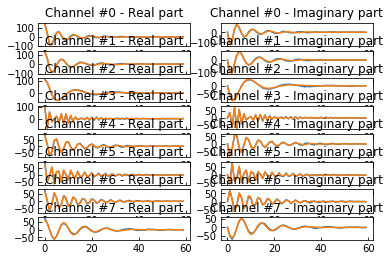

In [86]:
# Look at the modeling in the Fourier domain
model.get_results()
model.plot_fftprofiles()

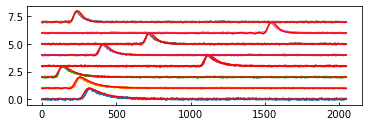

In [88]:
model.plot_profiles()

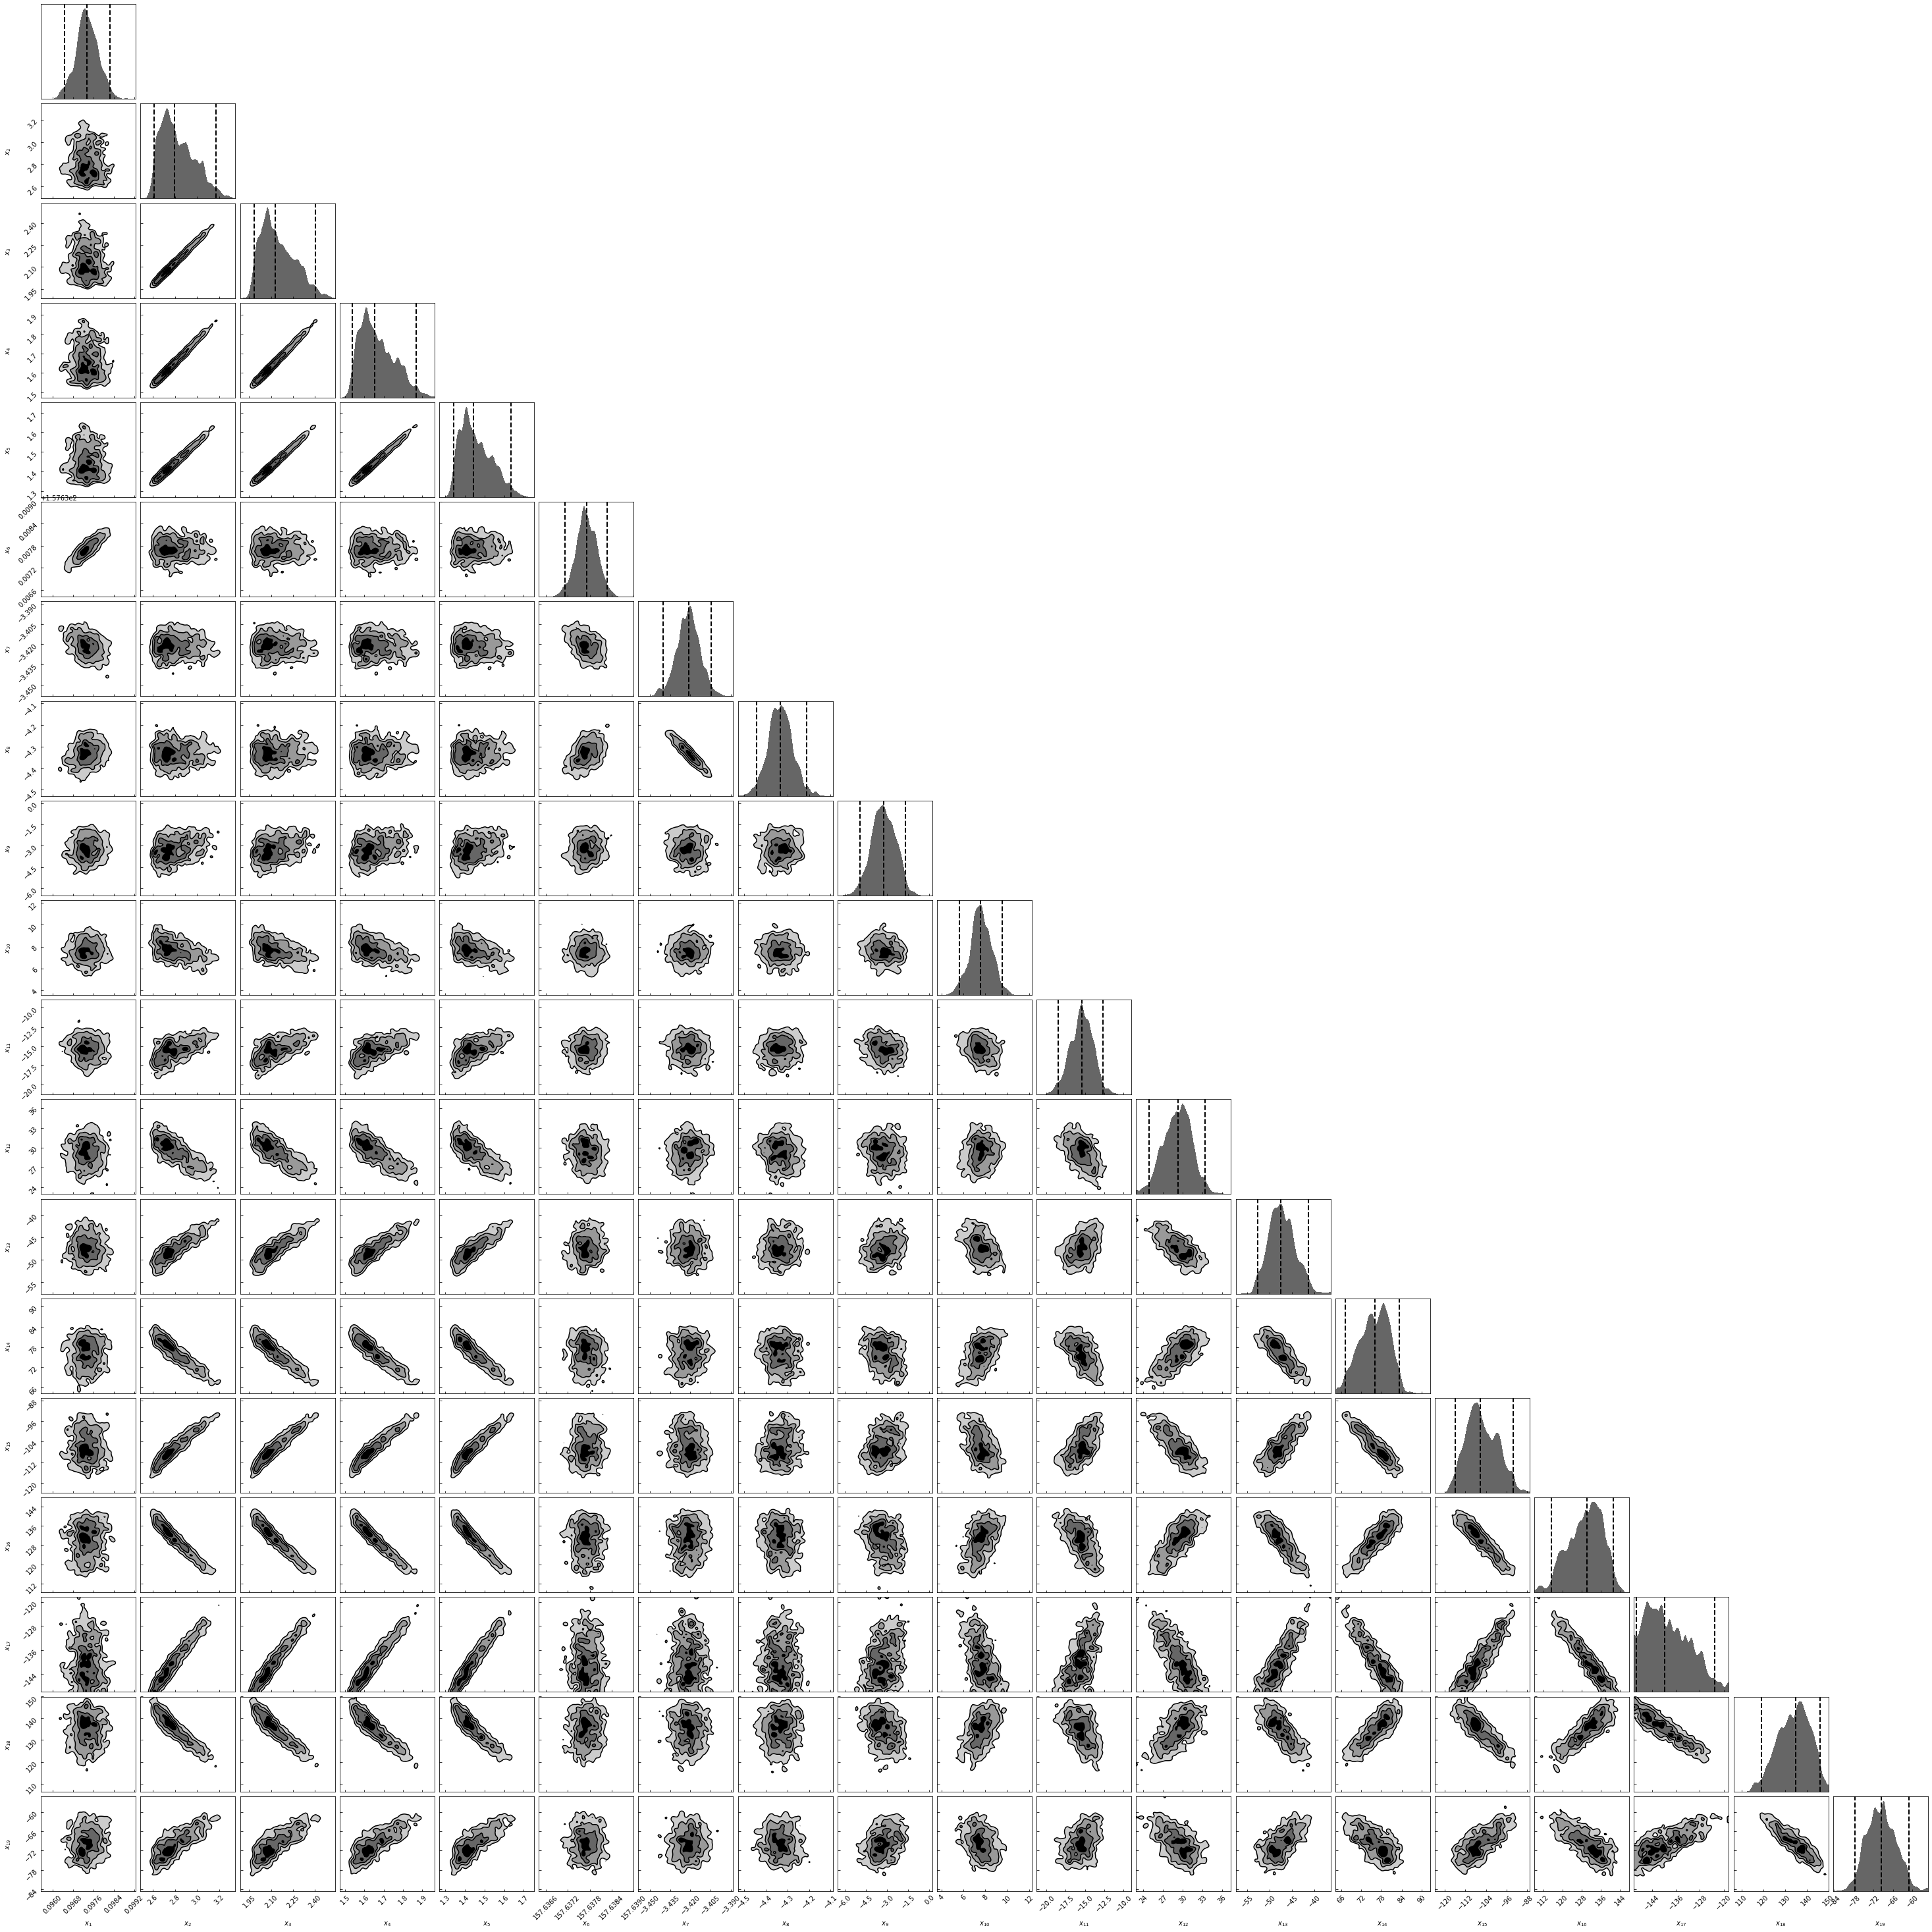

In [72]:
from dynesty import plotting as dyplot
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sampler.results)

In [60]:
print(model.get_results().T[1])

Npts = 120, Chi**2 = 33859.062111
[ 1.84169901e-02  3.83274232e+01  2.34925665e+01  1.57578198e+02
 -3.14492218e+00 -4.99927948e+00  3.02582388e+01  4.42798060e+01
 -3.46119345e+01]


In [9]:
ar = p.Archive_load(filename)
date = (ar.get_first_Integration().get_epoch().strtempo())

pfi = open(date+'.scattering','a')
pfi.write("%s %f %f \n"%(date, quantiles[3][0], quantiles[3][1]))
pfi.close()

NameError: name 'quantiles' is not defined

In [87]:
model.get_results()

Npts = 480, Chi**2 = 5869.663227


array([[ 1.11377681e-01,  1.11857508e-01,  1.12292825e-01],
       [ 4.81987267e+00,  5.53212792e+00,  6.33279186e+00],
       [ 4.28887835e+00,  4.90340600e+00,  5.63265011e+00],
       [ 3.65443174e+00,  4.17995161e+00,  4.80574076e+00],
       [ 3.16024770e+00,  3.62118398e+00,  4.14490474e+00],
       [ 2.77919591e+00,  3.18796768e+00,  3.66383139e+00],
       [ 2.48348414e+00,  2.84432754e+00,  3.25413060e+00],
       [ 2.27551375e+00,  2.60583036e+00,  2.98731367e+00],
       [ 2.13400131e+00,  2.44878659e+00,  2.81206214e+00],
       [ 1.57629026e+02,  1.57629246e+02,  1.57629463e+02],
       [-3.34834532e+00, -3.34550945e+00, -3.34282278e+00],
       [-4.99779240e+00, -4.99321756e+00, -4.98574317e+00],
       [-1.10668779e+01, -9.51278156e+00, -8.31907268e+00],
       [ 2.08731239e+01,  2.41733795e+01,  2.76529876e+01],
       [-4.75049588e+01, -4.14232398e+01, -3.59941076e+01],
       [ 5.41499256e+01,  6.19233991e+01,  7.13398811e+01],
       [-8.65781049e+01, -7.54662580e+01